In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Set rcParams
matplotlib.rcParams.update({'font.size': 6, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tnrange
import scipy.integrate

import os

Method to convert RGBA colors with a given alpha value to opaque RGB colors, using Python implementation of alpha compositing by User jakevdp on [Stack Overflow](https://stackoverflow.com/questions/33371939/calculate-rgb-equivalent-of-base-colors-with-alpha-of-0-5-over-white-background).

In [3]:
import matplotlib.colors
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Cascade of timers implementation

In [16]:
# Parameters to generate cascade of timers
N = 26
k_on_state = np.array([15000,]*N)
k_off_state = np.array([200,]*N)
k_deg_state = np.array([100,]*N)

thresholds = np.load(os.getcwd()+'/thresholds.npy')

k_on_delay = np.array([100] + [80,]*(N-2))
k_off_delay = np.array([100] + [80,]*(N-2))

hill = lambda x, k_d, n: x**n/(k_d**n + x**n)

def cascadeTimer(t, y):
    # Rate stimulus turns off
    k_stim_off = 100
    threshold_0 = 0.6
    
    # Number of chain states
    dydt = np.zeros(N*2) # one delay element per state
    
    # See main text - methods for equations
    dydt[0] = -k_stim_off*y[0]
    dydt[1] = k_on_state[0]*(1-y[1])*hill(y[0], threshold_0, 20) - k_off_state[0]*y[1]
    
    for i in range(2, N*2, 2):
        dydt[i] = k_on_delay[i//2-1]*(1-y[i])*y[i-1] - k_off_delay[i//2 - 1]*y[i]
        dydt[i+1] = k_on_state[i//2]*(1-y[i+1])*hill(y[i], thresholds[i//2-1], 20) - k_off_state[i//2]*y[i+1]
    return dydt

# Time course of cascade components

In [6]:
T = 0.2 # Total time to simulate (s)
dt = 1e-4 # Time step size (s)
t = np.arange(0, int(T/dt))*dt

In [18]:
## Simulate timer components in response to a PF spike

# Initial condition: all components in inactive state,
# PF spike sets component "A" to fully active
y0 = np.zeros(2*N)
y0[0] = 1

cascade_sol = scipy.integrate.solve_ivp(cascadeTimer, (0, 0.2), y0, dense_output = True)

In [20]:
cascade_output = cascade_sol.sol(t)

## Extended fig. 3d

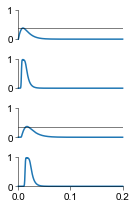

In [21]:
plt.figure(figsize=(2,3))

ax = plt.subplot(4,1,1)
plt.plot(t, cascade_output[2,:], clip_on=False)
plt.plot([0, 0.2], [thresholds[0],]*2, c='k', lw=0.5)
plt.ylim([0, 1])
plt.xlim([0, 0.2])

ax.xaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(4,1,2)
plt.plot(t, cascade_output[3,:], clip_on=False)

plt.ylim([0, 1])
plt.xlim([0, 0.2])
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax =plt.subplot(4,1,3)
plt.plot(t, cascade_output[4,:], clip_on=False)
plt.plot([0, 0.2], [thresholds[1],]*2, c='k', lw=0.5)
plt.ylim([0, 1])
plt.xlim([0, 0.2])
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax =plt.subplot(4,1,4)
plt.plot(t, cascade_output[5,:], clip_on=False)

plt.ylim([0, 1])
plt.xlim([0, 0.2])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout();

## Time course of all timer activations (cf. Fig. 3d)

In [33]:
# Collect only the timer activations
timers = cascade_output[1:N*2:2, :]

(0, 0.2)

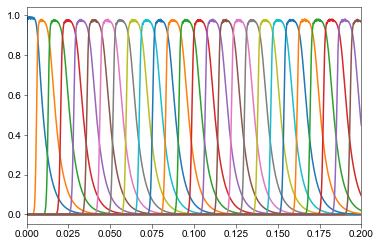

In [34]:
plt.plot(t, timers.T);
plt.xlim([0, 0.2])

### Eligibility window from a uniform sum of timers (Fig. 3d, "initial eligibility")

(Using 24 timers for visualization)

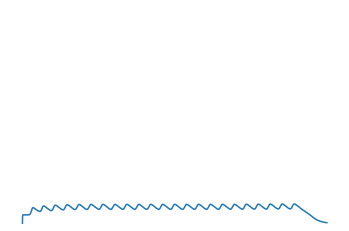

In [38]:
plt.plot(t,1/24*np.ones(24)@timers[:-2,:])
plt.ylim([0, 1])
plt.axis('off');

### Change in eligibility window after selection of timer 16
I.e., one slice of the selection window for a given value of CF time

Timer 16 was chosen arbitrarily for illustration purposes

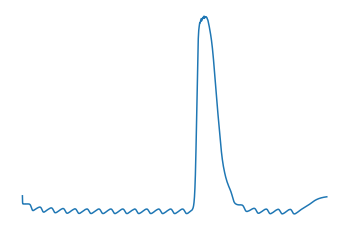

In [39]:
w_post_cf_example = -np.ones(24)/(23)
w_post_cf_example[15] = 1

plt.plot(t,w_post_cf_example@timers[:-2,:] )
plt.axis('off');

### Eligibility window after selection of timer 16 (Fig. 3d, "$\Delta$ Eligibility")

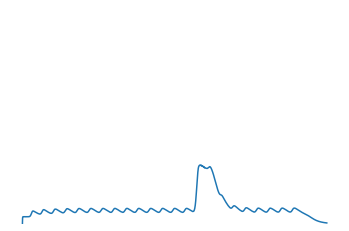

In [48]:
plt.plot(t, (1/24*np.ones(24)+0.2*w_post_cf_example)@timers[:-2,:])
plt.ylim([0, 1])
plt.axis('off');

# Timer selection window (Fig. 3d)

In [40]:
# Find time of peak activations for each timer
t_peaks = t[[np.argmax(timers[i,:]) for i in range(timers.shape[0])]]

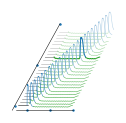

In [44]:
plt.figure(figsize=(2,2))

# Change the alpha value of colors linearly
# as we plot each timer activation sequentially
min_shade = 0.3
max_shade = 1
slope = (max_shade - min_shade)/24
c0 = matplotlib.colors.to_rgb('C0')
c2 = matplotlib.colors.to_rgb('C2')
white = [1,1,1]
y_offset = 0.02
x_offset = 0.001

# To make the quasi-3d effect, we plot each timer activation
# as linearly offset in x and y space
y_slope = 20
y_axis_offset = -0.055
x_axis_offset = -0.01

# Plot the "axes"
plt.plot([y_axis_offset+x_axis_offset, y_axis_offset+0.2], [x_axis_offset*y_slope, y_slope*0.2], c='k', lw=0.5 )
plt.plot([-0.04+x_axis_offset, 0.2], [x_axis_offset*y_slope, x_axis_offset*y_slope], c='k', lw=0.5)

# Scatter plot represents "tick marks" at known values
plt.scatter([y_axis_offset, y_axis_offset+0.1, y_axis_offset+0.2, 0, 0.1, 0.2],
            [0, y_slope*0.1, y_slope*0.2, x_axis_offset*y_slope, x_axis_offset*y_slope, x_axis_offset*y_slope], s=2)

for i in range(23,-1, -1):
    w_post_cf = -np.ones(24)/23
    w_post_cf[i] = 1
    trace = w_post_cf@timers[:-2] # Change in Eligibility window
    max_t = t[np.argmax(timers[i,:])]
    if i > 0:
        
        # Color areas of each slice of selection window as
        # Blue where Delta eligibility > 0
        # Green where Delta eligibility < 0
        pos_inds = np.where(trace > 0)[0]
        
        if i==15:
            lw = 1
            pos_color = c0
            neg_color = c2
        else:
            lw=0.5
            pos_color = make_rgb_transparent(c0, white, max_shade-slope*i)
            neg_color = make_rgb_transparent(c2, white, max_shade-slope*i)
        
        # Plot time course before tau = 0 in grey
        plt.plot([-0.04+t_peaks[i], t_peaks[i]-dt], [trace[0]+t_peaks[i]*y_slope,]*2, c=make_rgb_transparent((0.4,0.4,0.4), white, max_shade-slope*i), lw=lw)
        
        # Plot colored selection window slice
        plt.plot(t[pos_inds[-1]+1:]+t_peaks[i], trace[pos_inds[-1]+1:]+t_peaks[i]*y_slope, c=neg_color, lw=lw)
        plt.plot(t[pos_inds[0]:pos_inds[-1]+1]+t_peaks[i], trace[pos_inds[0]:pos_inds[-1]+1]+t_peaks[i]*y_slope, c=pos_color, lw=lw)
        plt.plot(t[:pos_inds[0]]+t_peaks[i], trace[:pos_inds[0]]+t_peaks[i]*y_slope, c=neg_color, lw=lw)
    else:
        plt.plot([-0.04+t_peaks[i], t_peaks[i]], [t_peaks[i]*y_slope,]*2, c=make_rgb_transparent((0,0,0), white, max_shade-slope*i), lw=0.5)
        plt.plot(t[:pos_inds[-1]+1], trace[:pos_inds[-1]+1]+t_peaks[i]*y_slope, c=make_rgb_transparent(c0, white, max_shade-slope*i), lw=0.5 )
        plt.plot(t[pos_inds[-1]+1:], trace[pos_inds[-1]+1:]+t_peaks[i]*y_slope, c=make_rgb_transparent(c2, white, max_shade-slope*i), lw=0.5 )
        
plt.axis('off');

# Slices of selection window for fixed time $\tau$ (Ext. Fig. 3h)

In [50]:
dw_mat = -np.ones((24,24))/23
dw_mat += np.diag(np.ones(24)/23 + 1)

selection_window = dw_mat@timers[:-2,:]

In [53]:
def getSelectionWindowTime(tau):
    tau_ind = (int)(np.floor(tau/dt))
    max_inds = np.argmax(timers[:-2], axis=0)
    window = np.zeros(len(t))
    for tt in range(len(t)):
        window[tt] = selection_window[max_inds[tt], tau_ind]
    return window

In [54]:
window_120 = getSelectionWindowTime(0.12)
window_0 = getSelectionWindowTime(0.04)

These windows are slices of the selection window above, but taken perpendicularly to the way they are plotted above. For two fixed time values, $\tau = 40$ ms and $\tau = 120$ ms, these windows indicate how the value of the eligibility window at that time should change as a function of CF time.

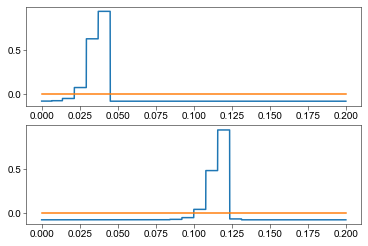

In [55]:
plt.subplot(2,1,1)
plt.plot(t, window_0)
plt.plot([0, 0.2], [0,0])

plt.subplot(2,1,2)
plt.plot(t, window_120)
plt.plot([0, 0.2], [0,0]);

In [56]:
np.save('cascade_timers.npy',timers)

# Timer selection ATTRAP rule with fixed updates

### Distribution of PF-CF intervals

In [4]:
timers = np.load('cascade_timers.npy')

In [5]:
dt = 1e-4
t = np.arange(0, int(0.2/dt))*dt
distr = np.exp(-(t-0.05)**2/(2*0.05**2)) + 2*np.exp(-(t-0.15)**2/(2*0.01**2))
distr /=np.sum(distr)

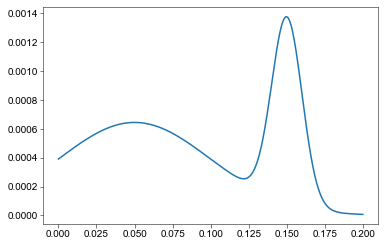

In [7]:
plt.plot(t, distr)

In [52]:
def selectionFixed(v_initial, distr, its=5000000, dv = 1e-4, report_its = 10000):
    """Simulate ATTRAP with fixed update method of timer selection mechanism.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    get_interval = lambda r: np.interp(r, cdf, t)
    get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 0

    num_states = timers.shape[0]
    active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)))
    v = np.copy(v_initial)

    for it in tnrange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        timer_vals = timers[:,get_interval_NN(np.random.rand())]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)

        # Shouldn't end up with negative weights
        timers_to_update = (v>0)
        timers_to_update[active_timer] = False
        num_active_timers = np.sum(timers_to_update)

        if num_active_timers > 0:
            dv_minus = np.zeros(num_states)
            # Decrease coupling weights of all timers except the most active (ind_to_increase)
            dv_minus[timers_to_update] = np.minimum(v[timers_to_update], dv)
            dv_minus[active_timer] = 0

            # Add weight changes
            v -= dv_minus
            
            v[active_timer] += np.sum(dv_minus)

        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

In [18]:
# Set initial condition
v0 = np.zeros(timers.shape[0])
v0[0] = 1

# Simulate ATTRAP
v_fixed, v_fixed_all = selectionFixed(v0, distr)

## Fig. 3f

Simulating ATTRAP, we find that the simulation converges quickly to an eligibility window equal to timer 19's activation time course. Timer 19 contains the mode of the distribution, found at 0.15 s.

<BarContainer object of 26 artists>

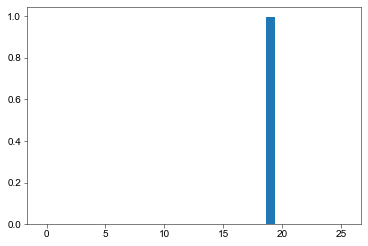

In [20]:
plt.bar(np.arange(timers.shape[0]), v_fixed)

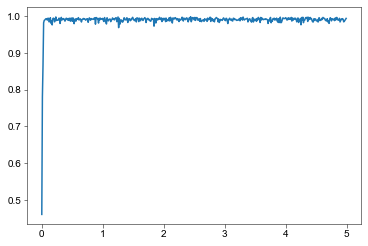

In [23]:
plt.plot(np.arange(v_fixed_all.shape[1])*10000/1e6, v_fixed_all[19,:])

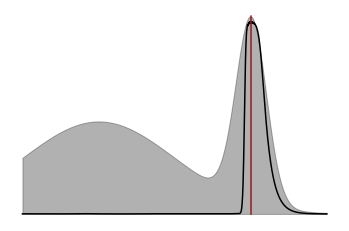

In [33]:
selected_window_fixed = v_fixed@timers

plt.plot(t, selected_window_fixed,c='k', zorder=10)
plt.plot([0.15,]*2, [0, 1], c='C3', zorder=10) # Mode of the distribution
plt.axis('off')
ax = plt.twinx()
plt.fill_between(t,0, distr, alpha=0.3, color='k', zorder=0)
plt.axis('off');

# Timer selection ATTRAP with proportional updates

In [27]:
def selectionProportional(v_initial, distr, its=5000000, dv = 1e-4, report_its = 10000):
    """Simulate ATTRAP with fixed update method of timer selection mechanism.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    get_interval = lambda r: np.interp(r, cdf, t)
    get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 0

    num_states = timers.shape[0]
    active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)))
    v = np.copy(v_initial)

    for it in tnrange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        timer_vals = timers[:,get_interval_NN(np.random.rand())]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)
        
        # Update weights
        v_ = v*(1-dv)
        v_[active_timer] = v[active_timer] + dv*(1-v[active_timer])
        v = np.copy(v_)
        
        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

In [28]:
# Set initial condition
v0 = np.zeros(timers.shape[0])
v0[0] = 1

# Simulate ATTRAP
v_proportional, v_proportional_all = selectionProportional(v0, distr)

## Figure 3f

Simulating ATTRAP using proportional update method of selection mechanism yields an eligibility window that approximates the PF/CF interval distribution.

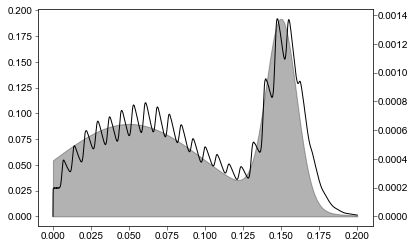

In [29]:
plt.plot(t, v_proportional@timers, c='k', lw=1)

ax = plt.twinx()
plt.fill_between(t, 0, distr/np.sum(distr), color='k', alpha=0.3)

# Idealized timer models

Here we consider an idealized set of timer activations given by narrow Gaussians that tile time after PF input. We first investigate the ability of the fixed update method to pick out the mode of the PF/CF interval distribution.

In [39]:
T = 0.2
dt = 1e-4
t = np.arange(0, int(T/dt))*dt

num_ideal_timers = 100
timers = np.zeros((num_ideal_timers, len(t)))
centers = np.linspace(0, 0.2, num_ideal_timers)
for i in range(num_ideal_timers):
    timers[i,:] = np.exp(-(t - centers[i])**2/(2*(2e-3)**2))

## Fixed updates - Extended data fig. 3g
We use bimodal distributions with peaks that differ by 20% in probability.

In [46]:
distr = 1.2*np.exp(-(t-0.05)**2/(2*0.01**2)) + np.exp(-(t-0.15)**2/(2*0.005**2))
distr /=np.sum(distr)

In [53]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal, v_fixed_ideal_all = selectionFixed(v_initial, distr, its=10000000, report_its=10000, dv=1e-5)

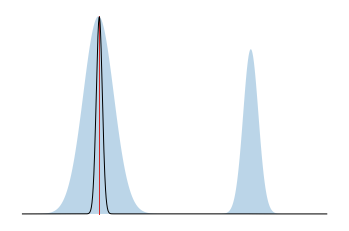

In [54]:
plt.fill_between(t, 0, distr, alpha=0.3)
plt.axis('off')
ax = plt.twinx()
plt.plot([t[np.argmax(distr)],]*2, [0, 1], lw=1, c='C3')
plt.plot(t, v_fixed_ideal@timers, lw=1, c='k')

plt.axis('off');

In [55]:
distr = np.exp(-(t-0.05)**2/(2*0.01**2)) + 1.2*np.exp(-(t-0.15)**2/(2*0.005**2))
distr /=np.sum(distr)

In [56]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal, v_fixed_ideal_all = selectionFixed(v_initial, distr, its=10000000, report_its=10000, dv=1e-5)

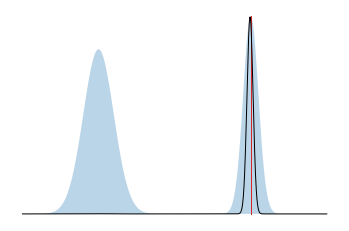

In [57]:
plt.fill_between(t, 0, distr, alpha=0.3)
plt.axis('off')
ax = plt.twinx()
plt.plot([t[np.argmax(distr)],]*2, [0, 1], lw=1, c='C3')
plt.plot(t, v_fixed_ideal@timers, lw=1, c='k')

plt.axis('off');

In [68]:
N_sims = 10
v_finals = np.zeros((N_sims, states.shape[0]))
v_peaks = np.zeros((N_sims, 2, 1000))
for n in tnrange(N_sims):
    v_initial = np.zeros(timers.shape[0])
    v_initial[0] = 1

    v_final, v_fixed_all = selectionFixed(v_initial, distr, its=10000000, report_its=10000, dv=1e-5)
    v_finals[n,:] = v_final
    v_peaks[n,0,:] = v_fixed_all[0,:]
    v_peaks[n,1,:] = v_fixed_all[74,:]

In [69]:
v_peaks_avg = np.mean(v_peaks, axis=0)
v_peaks_std = np.std(v_peaks, axis=0)

In [81]:
v_peaks_std.shape

(2, 1000)

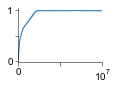

In [86]:
plt.figure(figsize=(1.5, 1))

it_inds = np.arange(v_peaks_avg.shape[1])

# plt.plot(it_inds, v_peaks_avg[0,:])
# plt.fill_between(it_inds, v_peaks_avg[0,:] - v_peaks_std[0,:], v_peaks_avg[0,:] + v_peaks_std[0,:], alpha=0.3)
plt.plot(np.arange(v_peaks_avg.shape[1]), v_peaks_avg[1,:], lw=1)
plt.fill_between(it_inds, v_peaks_avg[1,:] - v_peaks_std[1,:], v_peaks_avg[1,:] + v_peaks_std[1,:], alpha=0.3)

plt.yticks([0, 0.5, 1], [0, '', 1]);
plt.xticks([0, 500, 1000], [0, '', r'$10^7$'])

# plt.ylim([0, 1])
plt.xlim([0, 1000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

## Proportional updates - Ext. data fig. 3g

In [87]:
dt = 1e-4
t = np.arange(0, int(0.2/dt))*dt
distr = np.exp(-(t-0.05)**2/(2*0.05**2)) + 2*np.exp(-(t-0.15)**2/(2*0.01**2))
distr /=np.sum(distr)

In [91]:
# Set initial condition
v0 = np.zeros(timers.shape[0])
v0[0] = 1

# Simulate ATTRAP
v_proportional_ideal, v_proportional_ideal_all = selectionProportional(v0, distr, dv=1e-5)

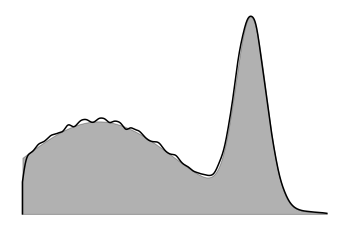

In [92]:
plt.fill_between(t, 0, distr, color='k', alpha=0.3)
plt.axis('off')
ax = plt.twinx()
plt.plot(np.concatenate((np.array([0]), t)), np.concatenate((np.array([0]), v_proportional_ideal@timers)), c='k')
plt.axis('off');